# Run Camera Calibration to Remove Distortion

Determine calibration matrices corresponding to lens abberation. This can then be used to cancel out the distortion on the camera's images. This is important for the Spatial Power spectrum, as these distortions change the resulting spatial frequencies

## Dependencies

In [94]:
import os, stat
import numpy as np
import msgpack
import cv2
import matplotlib.pyplot as plt
import utils.traceconvert as traceconvert
import random
import glob
import yaml
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15.0, 10.0)


## Parameters

*** NOTE: REALLY NEED TO CHECK ON THE VALUES FOR HORIZONTAL AND VERTICAL FOV ***

In [95]:
#base_dir = '/hmet_data/pilot2_dec2020/'
#data_dir = os.path.join(base_dir, 'raw', '2020_11_27', '000')
base_dir = '/hmet_data/ago_pilot_feb2020/'
#data_dir = os.path.join(base_dir)
data_dir = os.path.join(base_dir, 'raw', '2020_02_26', '011')
output_dir = os.path.join(base_dir, 'analysis')
#output_dir = './output/matched_frames'

fps = 200

###DEFINITELY NEED TO CHECK ON THESE VALUES
horizontal_fov_deg = 61
#vertical_fov_deg = 61

img_dims=(1544,2064)
save_batchsize = 200


## Specify Directories for Exmaple

In [96]:
example_subject = 'ag'
example_trial = 'sandwich'
iteration = '1'
trial_directory = os.path.join(data_dir, example_subject, iteration)
pngs_dir = os.path.join(base_dir, 'pngs', example_trial, example_subject, iteration)
save_dir = os.path.join('./output', example_trial, example_subject, iteration)
try:
    os.makedirs(save_dir)
except:
    print(f'{save_dir} already made!')

# analysis_folder = os.path.join(output_dir, example_trial, example_subject, iteration)
# common_timeline_file = os.path.join(analysis_folder,'common_timeline.csv')
# common_timeline_file_ximea = os.path.join(analysis_folder,'common_timeline_ximea_sampleidx.csv')
# common_timeline_file_rsrgb = os.path.join(analysis_folder,'common_timeline_rsrgb_sampleidx.csv')
# common_timeline_file_depth = os.path.join(analysis_folder,'common_timeline_depth_sampleidx.csv')
# common_timeline_file_pupil = os.path.join(analysis_folder,'common_timeline_pupil_sampleidx.csv')
#pupil_positions_file = os.path.join(trial_directory, 'eye_camera','000','exports','000','pupil_positions.csv')

#three trace conditions: true, none, temporal_match, spatial_match 
#trace_type='fixation_eye_0
#trace_type='none'


./output/sandwich/ag/1 already made!


## Matched Frameset

In [127]:
common_timeline_file = os.path.join(analysis_folder,'common_timeline.csv')
common_timeline_depth_idx_file = os.path.join(analysis_folder, 'common_timeline_depth_sampleidx.csv')
common_timeline_rsrgb_idx_file = os.path.join(analysis_folder, 'common_timeline_rsrgb_sampleidx.csv')
common_timeline_ximea_idx_file = os.path.join(analysis_folder, 'common_timeline_ximea_sampleidx.csv')
common_timeline_pupil_idx_file = os.path.join(analysis_folder, 'common_timeline_pupil_sampleidx.csv')

common_timeline = np.genfromtxt(common_timeline_file)
common_timeline_depth_idx = np.genfromtxt(common_timeline_depth_idx_file)
common_timeline_rsrgb_idx = np.genfromtxt(common_timeline_rsrgb_idx_file)
common_timeline_ximea_idx = np.genfromtxt(common_timeline_ximea_idx_file)
common_timeline_pupil_idx = np.genfromtxt(common_timeline_pupil_idx_file)

#these should all be the same length
print(len(common_timeline), len(common_timeline_depth_idx),len(common_timeline_rsrgb_idx),len(common_timeline_ximea_idx ),len(common_timeline_pupil_idx ))

print(data_dir)

27253 27253 27253 27253 27253


In [134]:
pupil_l_movie_path

'/hmet_data/ago_pilot_feb2020/raw/2020_02_26/011/eye1.mp4'

In [187]:
rsrgb_movie_path =  os.path.join(data_dir, 'world.mp4')
pupil_l_movie_path =  os.path.join(data_dir, 'eye1.mp4')
pupil_r_movie_path =  os.path.join(data_dir, 'eye0.mp4')


cap = cv2.VideoCapture(rsrgb_movie_path)
cap_pup_l = cv2.VideoCapture(pupil_l_movie_path)
cap_pup_r = cv2.VideoCapture(pupil_r_movie_path)


#common_timeline = np.loadtxt(common_timeline_file)
#common_timeline_ximea_idx = np.loadtxt(common_timeline_file_ximea)
#common_timeline_rsrgb_idx = np.loadtxt(common_timeline_file_rsrgb)
#common_timeline_depth_idx = np.loadtxt(common_timeline_file_depth)
#common_timeline_pupil_idx = np.loadtxt(common_timeline_file_pupil)


maxframes = 100

rerun=False

if(rerun):
    os.makedirs(os.path.join(output_dir,'matched_frames','depth'),exist_ok=True)
    os.makedirs(os.path.join(output_dir,'matched_frames','rsrgb'),exist_ok=True)
    os.makedirs(os.path.join(output_dir,'matched_frames','ximea'),exist_ok=True)
    os.makedirs(os.path.join(output_dir,'matched_frames','pupil_left'),exist_ok=True)
    os.makedirs(os.path.join(output_dir,'matched_frames','pupil_right'),exist_ok=True)
    for i in range(np.min((len(common_timeline),maxframes))):
        print('*',end='')

        #save appropriate depth file as png
        #might need to zfill with 8 later str(int(common_timcommon_timeline_depth_idx)).zfill(8)
        depth_in_path = os.path.join(data_dir, 'depth', f'depth_frame_{int(common_timeline_depth_idx[i])}.npy')
        #depth_out_path = os.path.join(output_dir, 'matched_frames','depth',f'depth_frame_{i}.png')
        depth_out_path = os.path.join(output_dir, 'matched_frames','depth',f'depth_frame_{i}.npy')
        depth_frame = np.load(depth_in_path)
        #cv2.imwrite(depth_out_path, depth_frame)
        np.save(depth_out_path, depth_frame)

        #save appropriate rsrgb frame as png
        cap.set(1, int(common_timeline_rsrgb_idx[i]))
        res, rsrgb_frame = cap.read()
        rsrgb_out_path = os.path.join(output_dir, 'matched_frames','rsrgb',f'rsrgb_frame_{i}.png')
        cv2.imwrite(rsrgb_out_path, rsrgb_frame)

        #save appropriate ximea frame as png
        ximea_in_path = os.path.join(pngs_dir, f'frame_{int(common_timeline_ximea_idx[i])}.png')
        ximea_out_path = os.path.join(output_dir, 'matched_frames','ximea',f'ximea_frame_{i}.png')
        ximea_frame = cv2.imread(ximea_in_path)
        cv2.imwrite(ximea_out_path, ximea_frame)
        
        #save appropriate pupil Left frame as png
        cap_pup_l.set(1, int(common_timeline_pupil_idx[i]))
        res, pup_l_frame = cap_pup_l.read()
        pup_l_out_path = os.path.join(output_dir, 'matched_frames','pupil_left',f'pupil_l_frame_{i}.png')
        cv2.imwrite(pup_l_out_path, pup_l_frame)

        #save appropriate pupil Right frame as png
        cap_pup_r.set(1, int(common_timeline_pupil_idx[i]))
        res, pup_r_frame = cap_pup_r.read()
        pup_r_out_path = os.path.join(output_dir, 'matched_frames','pupil_right',f'pupil_r_frame_{i}.png')
        cv2.imwrite(pup_r_out_path, pup_r_frame)
        

    cap.release()
else:
    i=22
    rsrgb_frame = cv2.imread(os.path.join(output_dir, 'matched_frames','rsrgb',f'rsrgb_frame_{i}.png'))
    depth_frame = np.load(os.path.join(output_dir, 'matched_frames','depth',f'depth_frame_{i}.npy'))
    ximea_frame = cv2.imread(os.path.join(output_dir, 'matched_frames','ximea',f'ximea_frame_{i}.png'))
    pup_l_frame = cv2.imread(os.path.join(output_dir, 'matched_frames','pupil_left',f'pupil_l_frame_{i}.png'))
    pup_r_frame = cv2.imread(os.path.join(output_dir, 'matched_frames','pupil_right',f'pupil_r_frame_{i}.png'))


## Adjust Frames

In [188]:
ximea_frame = cv2.cvtColor(ximea_frame, cv2.COLOR_BGR2RGB) #rgb
depth_frame = depth_frame/1000 #convert mm to meters
pup_r_frame = cv2.flip(pup_r_frame,0) #eye is flipped

# equalize the histogram of the Y channel
# ximea_yuv = cv2.cvtColor(ximea_frame, cv2.COLOR_RGB2YUV)
# ximea_yuv[:,:,0] = cv2.equalizeHist(ximea_yuv[:,:,0])
# # convert the YUV image back to RGB format
# ximea_frame_eq = cv2.cvtColor(ximea_yuv, cv2.COLOR_YUV2RGB)
# plt.imshow(ximea_frame_eq)

#quick and dirty actually looks better
ximea_frame_div = ximea_frame/50
ximea_frame_div[np.where(ximea_frame_div>1)] = 1


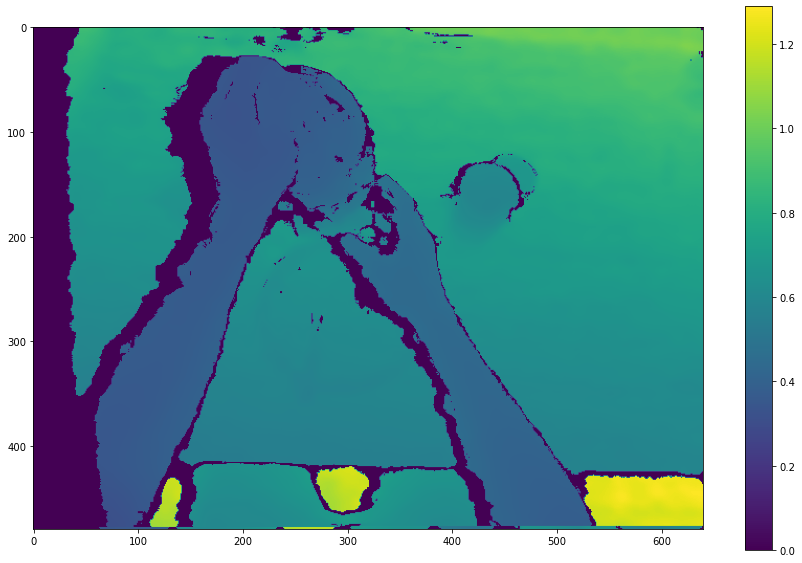

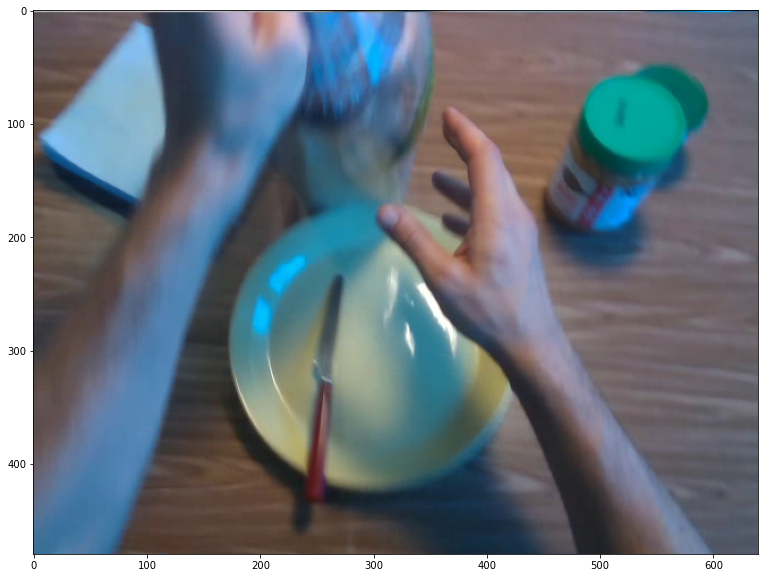

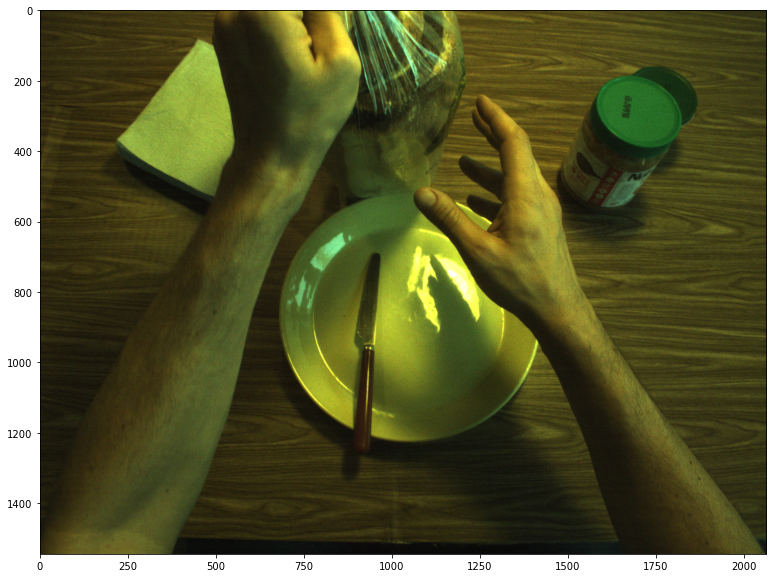

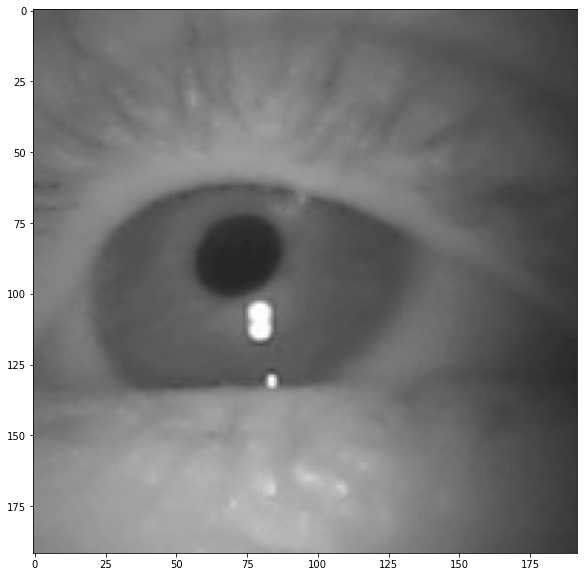

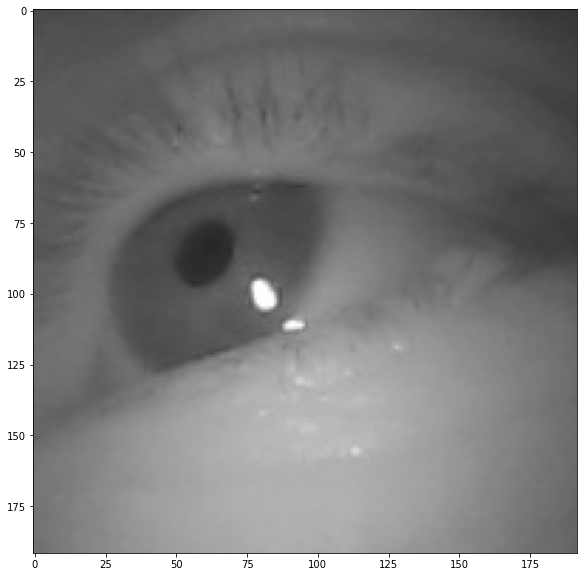

In [189]:
plt.imshow(depth_frame)
plt.colorbar()
plt.show()
plt.imshow(cv2.cvtColor(rsrgb_frame, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(ximea_frame_div)
plt.show()
plt.imshow(pup_l_frame)
plt.show()
plt.imshow(pup_r_frame)